In [1]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install cirq --quiet
    import cirq
    print("installed cirq.")

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def make_quantum_teleportation_circuit(gate):
    """Returns a circuit for quantum teleportation.
    
    This circuit 'teleports' a random qubit state prepared by
    the input gate from Alice to Bob.
    """
    circuit = cirq.Circuit()
    
    # Get the three qubits involved in the teleportation protocol.
    msg = cirq.NamedQubit("Message")
    alice = cirq.NamedQubit("Alice")
    bob = cirq.NamedQubit("Bob")
    
    # The input gate prepares the message to send.
    circuit.append(gate(msg))

    # Create a Bell state shared between Alice and Bob.
    circuit.append([cirq.H(alice), cirq.CNOT(alice, bob)])
    
    # Bell measurement of the Message and Alice's entangled qubit.
    circuit.append([cirq.CNOT(msg, alice), cirq.H(msg), cirq.measure(msg, alice)])

    # Uses the two classical bits from the Bell measurement to recover the
    # original quantum message on Bob's entangled qubit.
    circuit.append([cirq.CNOT(alice, bob), cirq.CZ(msg, bob)])

    return circuit

In [4]:
"""Visualize the teleportation circuit."""
# Gate to put the message qubit in some state to send.
gate = cirq.X ** 0.25

# Create the teleportation circuit.
circuit = make_quantum_teleportation_circuit(gate)
print("Teleportation circuit:\n")
print(circuit)

Teleportation circuit:

Alice: ─────H────────@───X───────M───@───────
                     │   │       │   │
Bob: ────────────────X───┼───────┼───X───@───
                         │       │       │
Message: ───X^0.25───────@───H───M───────@───


In [5]:
"""Display the Bloch vector of the message qubit."""
message = cirq.Circuit(gate.on(cirq.NamedQubit("Message"))).final_state_vector()
message_bloch_vector = cirq.bloch_vector_from_state_vector(message, index=0)
print("Bloch vector of message qubit:")
print(np.round(message_bloch_vector, 3))

Bloch vector of message qubit:
[-0.    -0.707  0.707]


In [6]:
# Get a simulator.
sim = cirq.Simulator()

# Simulate the teleportation circuit.
result = sim.simulate(circuit)

# Get the Bloch vector of Bob's qubit.
bobs_bloch_vector = cirq.bloch_vector_from_state_vector(result.final_state_vector, index=1)
print("Bloch vector of Bob's qubit:")
print(np.round(bobs_bloch_vector, 3))

# Verify they are the same state!
np.testing.assert_allclose(bobs_bloch_vector, message_bloch_vector, atol=1e-6)

Bloch vector of Bob's qubit:
[ 0.    -0.707  0.707]


## QAOA MAXCUT

In [7]:
from typing import List
import sympy
import numpy as np
import matplotlib.pyplot as plt

import cirq_google

working_device = cirq_google.Sycamore
print(working_device)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

# *****Base google Cirq****

In [5]:
# Pick a qubit.
qubit = cirq.GridQubit(0, 0)

# Create a circuit that applies a square root of NOT gate, then measures the qubit.
circuit = cirq.Circuit(cirq.X(qubit) ** 0.5, cirq.measure(qubit, key='m'))
print("Circuit:")
print(circuit)

# Simulate the circuit several times.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=20)
print("Results:")
print(result)

Circuit:
(0, 0): ───X^0.5───M('m')───
Results:
m=00100010101101010100


In [8]:
import cirq_google
# Using named qubits can be useful for abstract algorithms
# as well as algorithms not yet mapped onto hardware.
q0 = cirq.NamedQubit('source')
q1 = cirq.NamedQubit('target')

# Line qubits can be created individually
q3 = cirq.LineQubit(3)

# Or created in a range
# This will create LineQubit(0), LineQubit(1), LineQubit(2)
q0, q1, q2 = cirq.LineQubit.range(3)

# Grid Qubits can also be referenced individually
q4_5 = cirq.GridQubit(4, 5)

# Or created in bulk in a square
# This will create 16 qubits from (0,0) to (3,3)
qubits = cirq.GridQubit.square(4)
print(qubits)

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]


In [13]:
qubits = cirq.GridQubit.square(3)

print(qubits[0])
print(qubits)

q(0, 0)
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2)]


In [9]:
circuit = cirq.Circuit()
qubits = cirq.LineQubit.range(3)
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.H(qubits[1]))
circuit.append(cirq.H(qubits[2]))
print(circuit)

0: ───H───

1: ───H───

2: ───H───


In [10]:
circuit = cirq.Circuit()
ops = [cirq.H(q) for q in cirq.LineQubit.range(3)]
circuit.append(ops)
print(circuit)

0: ───H───

1: ───H───

2: ───H───


In [11]:
# Append with generator
circuit = cirq.Circuit()
circuit.append(cirq.H(q) for q in cirq.LineQubit.range(3))
print(circuit)
# Initializer with generator
print(cirq.Circuit(cirq.H(q) for q in cirq.LineQubit.range(3)))

0: ───H───

1: ───H───

2: ───H───
0: ───H───

1: ───H───

2: ───H───


In [12]:
print(cirq.Circuit(cirq.SWAP(q, q + 1) for q in cirq.LineQubit.range(3)))

0: ───×───────────
      │
1: ───×───×───────
          │
2: ───────×───×───
              │
3: ───────────×───


In [14]:
# Creates each gate in a separate moment by passing an iterable of Moments instead of Operations.
print(cirq.Circuit(cirq.Moment([cirq.H(q)]) for q in cirq.LineQubit.range(3)))

0: ───H───────────

1: ───────H───────

2: ───────────H───


In [15]:
# Create some qubits.
q0 = cirq.GridQubit(5, 6)
q1 = cirq.GridQubit(5, 5)
q2 = cirq.GridQubit(4, 5)

# Create operations using the Sycamore gate, which is supported by the Sycamore device.
# However, create operations for both adjacent and non-adjacent qubit pairs.
adjacent_op = cirq_google.SYC(q0, q1)
nonadjacent_op = cirq_google.SYC(q0, q2)

# A working circuit for the Sycamore device raises no issues.
working_circuit = cirq.Circuit()
working_circuit.append(adjacent_op)
valid = cirq_google.Sycamore.validate_circuit(working_circuit)

# A circuit using invalid operations.
bad_circuit = cirq.Circuit()
bad_circuit.append(nonadjacent_op)
try:
    cirq_google.Sycamore.validate_circuit(bad_circuit)
except ValueError as e:
    print(e)

Qubit pair is not valid on device: (cirq.GridQubit(5, 6), cirq.GridQubit(4, 5)).


In [ ]:
import networkx as nx

In [19]:
# Create a circuit to generate a Bell State:
# 1/sqrt(2) * ( |00⟩ + |11⟩ )
bell_circuit = cirq.Circuit()
q0, q1 = cirq.LineQubit.range(2)
bell_circuit.append(cirq.H(q0))
bell_circuit.append(cirq.CNOT(q0, q1))

# Initialize Simulator
s = cirq.Simulator()
print(bell_circuit)
print('Simulate the circuit:')
results = s.simulate(bell_circuit)
print(results)

# For sampling, we need to add a measurement at the end
bell_circuit.append(cirq.measure(q0, q1, key='result'))

# Sample the circuit
#samples = s.run(bell_circuit, repetitions=1000)

0: ───H───@───
          │
1: ───────X───
Simulate the circuit:
measurements: (no measurements)

qubits: (cirq.LineQubit(0), cirq.LineQubit(1))
output vector: 0.707|00⟩ + 0.707|11⟩

phase:
output vector: |⟩


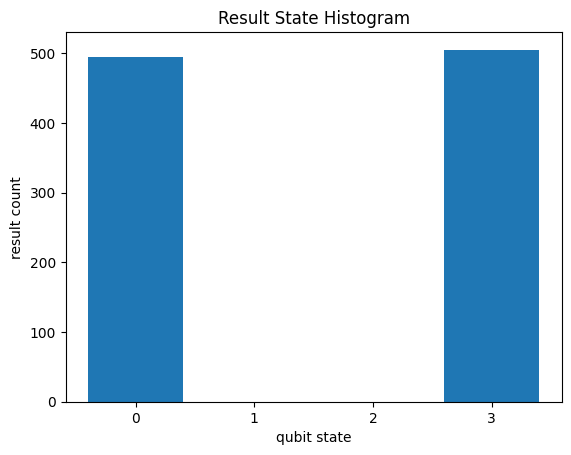

In [17]:
import matplotlib.pyplot as plt

cirq.plot_state_histogram(samples, plt.subplot())
plt.show()

Counter({3: 505, 0: 495})


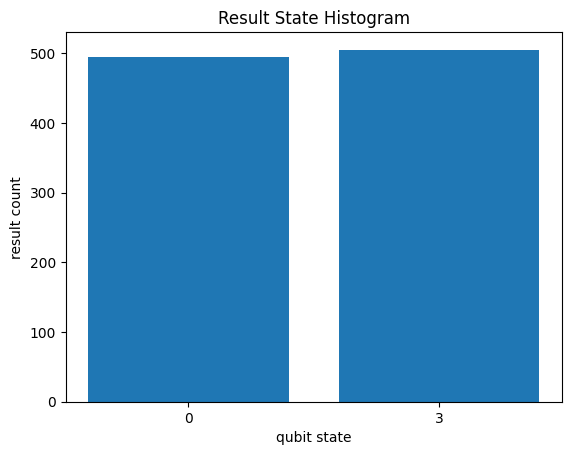

In [20]:
# Pull of histogram counts from the result data structure
counts = samples.histogram(key='result')
print(counts)

# Graph the histogram counts instead of the results
cirq.plot_state_histogram(counts, plt.subplot())
plt.show()

In [21]:
print('Unitary of the X gate')
print(cirq.unitary(cirq.X))

print('Unitary of SWAP operator on two qubits.')
q0, q1 = cirq.LineQubit.range(2)
print(cirq.unitary(cirq.SWAP(q0, q1)))

print('Unitary of a sample circuit')
print(cirq.unitary(cirq.Circuit(cirq.X(q0), cirq.SWAP(q0, q1))))

Unitary of the X gate
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
Unitary of SWAP operator on two qubits.
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
Unitary of a sample circuit
[[0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]
